In [35]:
import sys
print(sys.executable)

/Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/myenv/bin/python


In [36]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
env_path = f"{root_dir}/.env"

print(f"Looking for .env at: {env_path}")
os.environ["AQICN_API_KEY"] = "dummy_key_to_pass_validation"
if os.path.exists(env_path):
    print("✅ File found.")
    # OPTIONAL: Print content to check (be careful not to share this output if sharing screen)
    with open(env_path, 'r') as f:
        print("--- File Content Preview ---")
        print(f.read()) 
        print("----------------------------")
else:
    print("❌ File NOT found. Please create the .env file in this directory.")
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")


Local environment
Added the following directory to the PYTHONPATH: /Users/zhangman/Documents/GitHub/ID2223_Scalable_Machine_Learning_project
Looking for .env at: /Users/zhangman/Documents/GitHub/ID2223_Scalable_Machine_Learning_project/.env
✅ File found.
--- File Content Preview ---
HOPSWORKS_API_KEY="qxkEnJwgfDQAQ2Dz.0uxQmjuXvZvNHBOruWARm00GmpDRY6tb1DCvTvaxGn9rmVq8xfj6J2ftBT6ZhEJ2"
AQICN_API_KEY=
# Streaming in Credit Card Example
FELDERA_API_KEY=<Feldera API KEY VALUE>
# Clone feldera from github and store it in this directory
FELDERA_DIR=</home/$USER/feldera>

# LLM Examples
OPENAI_API_KEY=<OPENAI API KEY VALUE>
----------------------------
HopsworksSettings initialized!


In [37]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

In [38]:
project = hopsworks.login()

2026-01-11 19:34:09,125 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-11 19:34:09,160 INFO: Initializing external client
2026-01-11 19:34:09,160 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-11 19:34:10,757 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1342613


In [39]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 
# 2. Retrieve your Feature Group
release_fg = fs.get_feature_group(name='release_info', version=1)
print("Features in FG:", [f.name for f in release_fg.features])

2026-01-11 19:34:13,897 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-11 19:34:13,915 INFO: Initializing external client
2026-01-11 19:34:13,916 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-11 19:34:15,391 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1342613
Features in FG: ['full_name', 'repo_stars', 'repo_forks', 'repo_watchers', 'release_name', 'release_body', 'author_followers', 'author_public_repos', 'published_at', 'first_week_star', 'date_only', 'is_trending', 'repo_duration', 'org_author', 'user_author', 'publish_is_weekday', 'language__c', 'language__csharp', 'language__cplusplus', 'language__css', 'language__dart', 'language__go', 'language__html', 'language__java', 'language__javascript', 'language__kotlin', 'language__lua', 'language__other', 'language__php', 'language__python', 'language__qml', 'language__rust', 'language__shell', 'language__svelte', 'language__swift', 'language__typescript', 'language__vue']


In [41]:

from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Load your data (or read from Feature Group)
# df = release_fg.read() 

# --- STEP A: Filter "Future" Data (Leakage) ---
# We drop columns that show the repo's status *today* (2026), 
# because we only want to know what it looked like *at release time* (2025).
df = release_fg.read()
leakage_cols = ['repo_stars', 'repo_forks', 'repo_watchers', 'repo_updated_at']
df = df.drop(columns=[c for c in leakage_cols if c in df.columns])

# --- STEP B: Handle Dates (Drop raw date, keep signal) ---
# Convert to datetime if not already
df['published_at'] = pd.to_datetime(df['published_at'])
df['is_weekend'] = df['published_at'].dt.dayofweek >= 5

# Now DROP the raw date column (models can't use raw timestamps well)
df = df.drop(columns=['published_at'])

# --- STEP C: Turn Text to Numbers (Keywords) ---
# 1. Release Body (Look for "fix", "feature", "breaking")
tfidf_body = TfidfVectorizer(max_features=20, stop_words='english')
body_matrix = tfidf_body.fit_transform(df['release_body'].fillna(''))
# Create DataFrame with names like 'keyword_fix', 'keyword_feature'
body_df = pd.DataFrame(
    body_matrix.toarray(), 
    columns=[f"body_{k}" for k in tfidf_body.get_feature_names_out()]
)
print("release body key word"+body_df.columns)
# 2. Release Name (Look for "v1", "beta", "rc")
tfidf_name = TfidfVectorizer(max_features=5, token_pattern=r'(?u)\b\w+\b')
name_matrix = tfidf_name.fit_transform(df['release_name'].fillna(''))
name_df = pd.DataFrame(
    name_matrix.toarray(), 
    columns=[f"name_{k}" for k in tfidf_name.get_feature_names_out()]
)

# Join everything back together
print("release name key word"+name_df.columns)
df_train = pd.concat([df, body_df, name_df], axis=1)

# --- STEP D: Drop Non-Training Keys ---
# Drop the ID column (full_name) just before training
X = df_train.drop(columns=['full_name', 'release_body', 'release_name', 'date_only', 'first_week_star'])
y = df_train['first_week_star']

print("Final Training Features:", X.head())

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.82s) 
Index(['release body key wordbody_add', 'release body key wordbody_added',
       'release body key wordbody_agent', 'release body key wordbody_ai',
       'release body key wordbody_com', 'release body key wordbody_commit',
       'release body key wordbody_docs', 'release body key wordbody_feat',
       'release body key wordbody_fix', 'release body key wordbody_github',
       'release body key wordbody_https', 'release body key wordbody_mcp',
       'release body key wordbody_new', 'release body key wordbody_pull',
       'release body key wordbody_sh', 'release body key wordbody_superset',
       'release body key wordbody_support', 'release body key wordbody_update',
       'release body key wordbody_v0', 'release body key wordbody_vllm'],
      dtype='object')
Index(['release name key wordname_0', 'release name key wordname_1',
       'release name key wordname_2', 'release name key wordname_v0

In [42]:
# Run this to see the "Scale" of your features
print(df_train[['author_followers', 'repo_duration']].describe())

       author_followers  repo_duration
count       3804.000000    3804.000000
mean        3304.292061     222.957676
std        13947.041885      97.040488
min            0.000000       4.000000
25%           35.000000     153.000000
50%           84.000000     239.000000
75%          392.000000     303.000000
max       110990.000000     365.000000


In [43]:

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train XGBoost
# We use 'reg:squarederror' because this is a regression problem (predicting a number)
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost model...")
model.fit(X_train, y_train)

# 3. Predict & Evaluate
preds = model.predict(X_test)
preds = np.maximum(preds, 0) # Force predictions to be non-negative (can't have negative stars)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("-" * 30)
print(f"Mean Absolute Error (MAE): {mae:.2f} stars")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} stars")
print(f"R² Score: {r2:.4f} (Higher is better)")
print("-" * 30)

# 4. Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 5 Most Important Features:")
print(importances.head(5))

Training XGBoost model...
------------------------------
Mean Absolute Error (MAE): 98.94 stars
Root Mean Squared Error (RMSE): 184.27 stars
R² Score: 0.3043 (Higher is better)
------------------------------

Top 5 Most Important Features:
language__svelte    0.055473
language__csharp    0.053453
repo_duration       0.049847
language__swift     0.047940
language__c         0.045132
dtype: float32


In [44]:
print(y_test)

2014     23
527      67
478      13
1684     28
1653     10
       ... 
2254      1
1703      1
948       1
1483      4
2905    445
Name: first_week_star, Length: 761, dtype: int64


In [45]:
import matplotlib.pyplot as plt

# 1. Convert y_test to a DataFrame
df_plt = y_test.to_frame(name='Actual')

# 2. Add the predictions as a new column
df_plt['Predicted'] = preds

# 3. Sort it (Optional) - This makes the line plot much easier to read!
# We sort by 'Actual' so you can see the curve of stars rising.
df_plt_sorted = df_plt.sort_values(by='Actual').reset_index(drop=True)

In [46]:
print(df_plt)

      Actual   Predicted
2014      23   77.155655
527       67  104.377960
478       13   66.140472
1684      28   30.696957
1653      10   51.367928
...      ...         ...
2254       1   35.239571
1703       1   23.845154
948        1  126.789780
1483       4   27.678802
2905     445   67.210281

[761 rows x 2 columns]


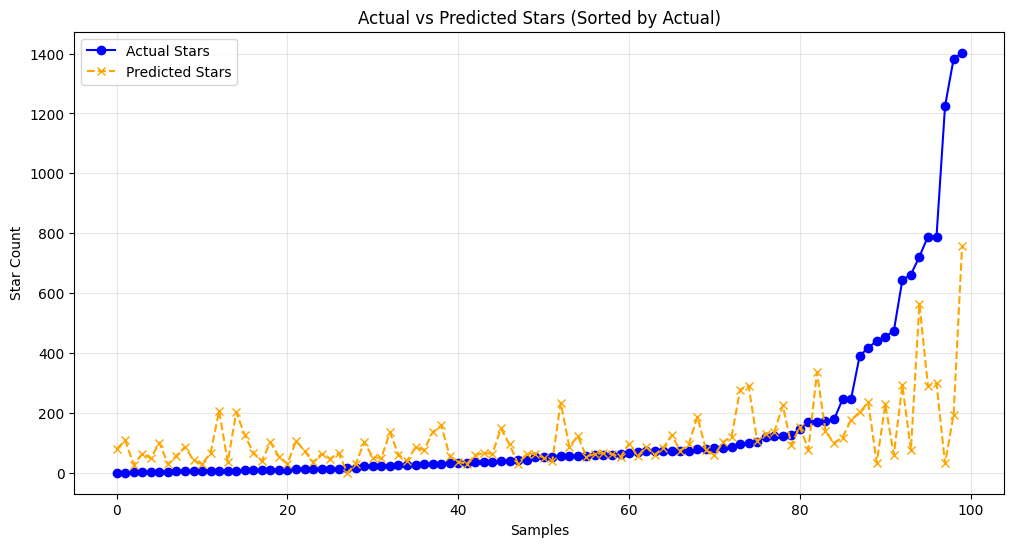

In [47]:
plt.figure(figsize=(12, 6))

subset = df_plt.sample(n=100, random_state=42)

# 3. SORT THE SUBSET (Critical for clean visualization!)
# We sort this specific random batch by 'Actual' values.
# This ensures the blue line goes from Low -> High smoothly.
subset = subset.sort_values(by='Actual').reset_index(drop=True)
plt.plot(subset.index, subset['Actual'], color='blue', label='Actual Stars', marker='o')
plt.plot(subset.index, subset['Predicted'], color='orange', label='Predicted Stars', linestyle='--', marker='x')

plt.title('Actual vs Predicted Stars (Sorted by Actual)')
plt.ylabel('Star Count')
plt.xlabel('Samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

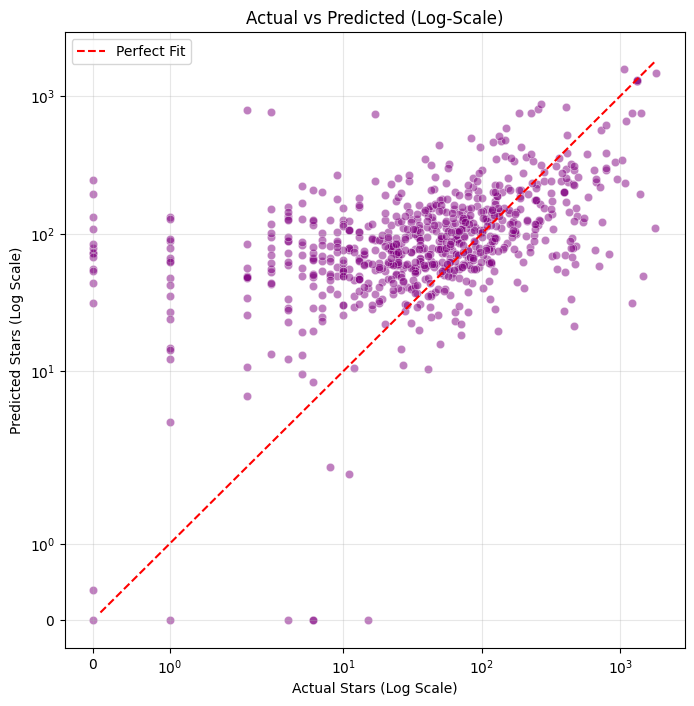

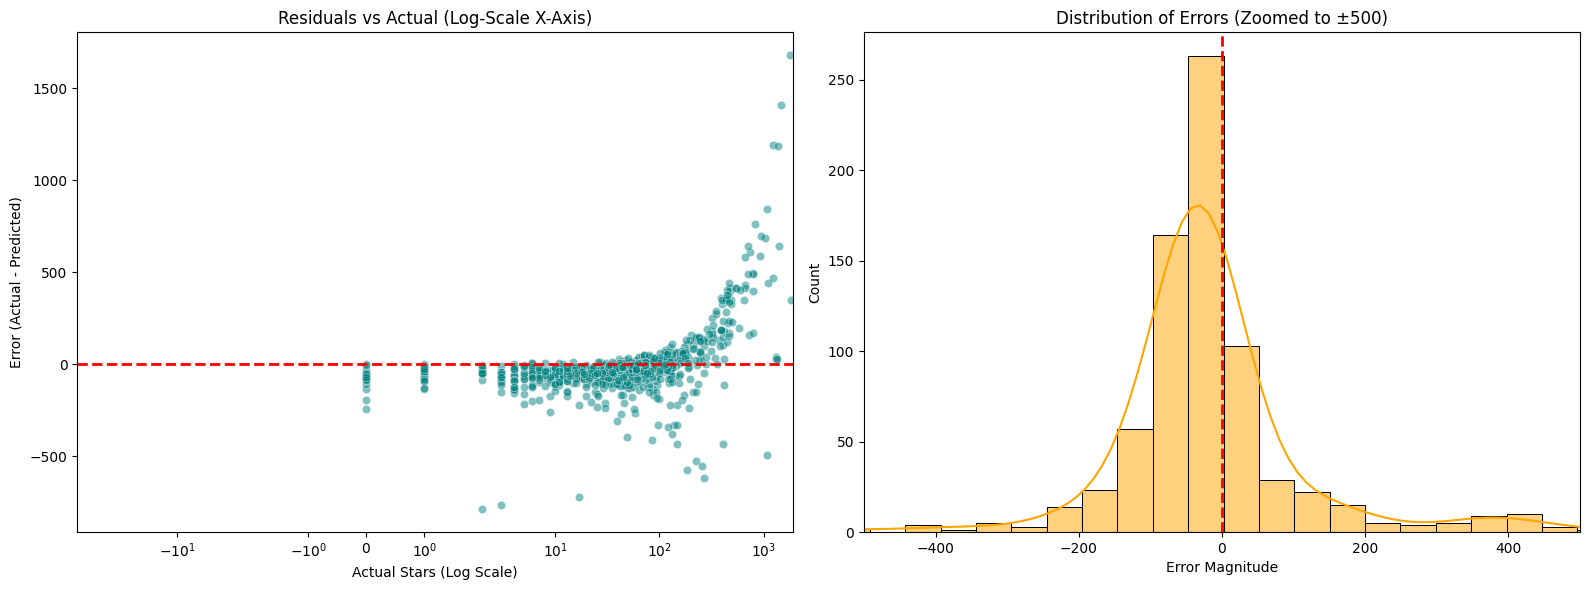

In [48]:

# 1. Prepare the data (Actual vs Predicted)
df_plt = y_test.to_frame(name='Actual')
df_plt['Predicted'] = preds

# 2. Plot with LOG SCALES
plt.figure(figsize=(8, 8))

# Scatter Plot
sns.scatterplot(x='Actual', y='Predicted', data=df_plt, alpha=0.5, color='purple')

# Perfect Fit Line
max_val = max(df_plt['Actual'].max(), df_plt['Predicted'].max())
plt.plot([0.1, max_val], [0.1, max_val], 'r--', label='Perfect Fit')

# --- THE MAGIC FIX: LOG SCALES ---
# We use 'symlog' (Symmetric Log) to handle 0 values gracefully
plt.xscale('symlog') 
plt.yscale('symlog')

plt.title('Actual vs Predicted (Log-Scale)')
plt.xlabel('Actual Stars (Log Scale)')
plt.ylabel('Predicted Stars (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# 1. Calculate Residuals
residuals = y_test - preds

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT 1: Residual Plot (Fixed with Log Scale) ---
sns.scatterplot(x=y_test, y=residuals, alpha=0.5, ax=axes[0], color='teal')
axes[0].axhline(0, color='red', linestyle='--', lw=2)

# THE FIX: This spreads out the "corner clump"
axes[0].set_xscale('symlog') 

axes[0].set_title('Residuals vs Actual (Log-Scale X-Axis)')
axes[0].set_xlabel('Actual Stars (Log Scale)')
axes[0].set_ylabel('Error (Actual - Predicted)')

# --- PLOT 2: Error Histogram (Zoomed In) ---
sns.histplot(residuals, bins=50, kde=True, ax=axes[1], color='orange')
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_title('Distribution of Errors (Zoomed to ±500)')
axes[1].set_xlabel('Error Magnitude')

# Optional: Zoom in to ignore massive outliers for a clearer view
axes[1].set_xlim(-500, 500) 

plt.tight_layout()
plt.show()

In [50]:
import joblib
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# 1. Save the Model and Vectorizers locally first
# We need the vectorizers to turn user text into numbers in the app
artifacts = {
    "model": model,
    "tfidf_body": tfidf_body,
    "tfidf_name": tfidf_name
}
joblib.dump(artifacts, 'model_XGB_artifacts.pkl')

# 2. Connect to Model Registry
mr = project.get_model_registry()

# 3. Define Input/Output Schema (Optional but recommended)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# 4. Upload to Hopsworks
# We create a model object and attach the file
github_model = mr.python.create_model(
    name="github_star_predictor_XGB", 
    version=2,
    metrics={"mae": mae, "r2": r2}, # Log your metrics from before
    model_schema=model_schema,
    description="Predicts first week stars based on release notes"
)

github_model.save('model_XGB_artifacts.pkl')

print("✅ Model and Vectorizers saved to Hopsworks!")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/zhangman/Documents/GitHub/ID2223_Scalable_Machine_Learning_project/model_XGB_artifacts.pkl: 0…

Uploading /Users/zhangman/Documents/GitHub/ID2223_Scalable_Machine_Learning_project/model_schema.json: 0.000%|…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1342613/models/github_star_predictor_XGB/2
✅ Model and Vectorizers saved to Hopsworks!
